In [1]:
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
df = pd.read_csv('../data/aw_fb_data.csv')
df.shape

(6264, 20)

# Data orientation

In [26]:
# drop this useless column
df.drop(columns=['Unnamed: 0'], inplace=True)
df.describe()

,X1,age,gender,height,weight,steps,hear_rate,calories,distance,entropy_heart,entropy_setps,resting_heart,corr_heart_steps,norm_heart,intensity_karvonen,sd_norm_heart,steps_times_distance
count,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000
mean,1771.144317,29.158525,0.476533,169.709052,69.614464,109.562268,86.142331,19.471823,13.832555,6.030314,5.739984,65.869938,0.306447,20.272393,0.155479,8.110854,590.035239
std,1097.988748,8.908978,0.499489,10.324698,13.451878,222.797908,28.648385,27.309765,45.941437,0.765574,1.256348,21.203017,0.775418,28.388116,0.210927,12.535080,4063.838530
min,1.000000,18.000000,0.000000,143.000000,43.000000,1.000000,2.222222,0.056269,0.000440,0.000000,0.000000,3.000000,-1.000000,-76.000000,-2.714286,0.000000,0.000690
25%,789.750000,23.000000,0.000000,160.000000,60.000000,5.159534,75.598079,0.735875,0.019135,6.108524,5.909440,58.134333,-0.467303,1.148883,0.009819,0.264722,0.659260
50%,1720.000000,28.000000,0.000000,168.000000,68.000000,10.092029,77.267680,4.000000,0.181719,6.189825,6.157197,75.000000,0.665829,9.820254,0.079529,2.893503,13.368619
75%,2759.250000,33.000000,1.000000,180.000000,77.300000,105.847222,95.669118,20.500000,15.697188,6.247928,6.247928,76.138701,1.000000,27.077336,0.211868,9.679672,93.728562
max,3670.000000,56.000000,1.000000,191.000000,115.000000,1714.000000,194.333333,97.500000,335.000000,6.475733,6.475733,155.000000,1.000000,156.319444,1.297980,74.457929,51520.000000


In [27]:
df.columns

Index(['X1', 'age', 'gender', 'height', 'weight', 'steps', 'hear_rate',
       'calories', 'distance', 'entropy_heart', 'entropy_setps',
       'resting_heart', 'corr_heart_steps', 'norm_heart', 'intensity_karvonen',
       'sd_norm_heart', 'steps_times_distance', 'device', 'activity'],
      dtype='object')

In [28]:
df.rename(
    columns={
        'X1': 'index',
        'hear_rate': 'heart_rate',
        'entropy_setps': 'entropy_steps',
    },
    inplace=True
)

In [29]:
df.head()

,index,age,gender,height,weight,steps,heart_rate,calories,distance,entropy_heart,entropy_steps,resting_heart,corr_heart_steps,norm_heart,intensity_karvonen,sd_norm_heart,steps_times_distance,device,activity
0,1,20,1,168.0,65.4,10.771429,78.531302,0.344533,0.008327,6.221612,6.116349,59.0,1.000000,19.531302,0.138520,1.000000,0.089692,apple watch,Lying
1,2,20,1,168.0,65.4,11.475325,78.453390,3.287625,0.008896,6.221612,6.116349,59.0,1.000000,19.453390,0.137967,1.000000,0.102088,apple watch,Lying
2,3,20,1,168.0,65.4,12.179221,78.540825,9.484000,0.009466,6.221612,6.116349,59.0,1.000000,19.540825,0.138587,1.000000,0.115287,apple watch,Lying
3,4,20,1,168.0,65.4,12.883117,78.628260,10.154556,0.010035,6.221612,6.116349,59.0,1.000000,19.628260,0.139208,1.000000,0.129286,apple watch,Lying
4,5,20,1,168.0,65.4,13.587013,78.715695,10.825111,0.010605,6.221612,6.116349,59.0,0.982816,19.715695,0.139828,0.241567,0.144088,apple watch,Lying


In [30]:
df['activity'].value_counts()

activity
Lying             1379
Running 7 METs    1114
Running 5 METs    1002
Running 3 METs     950
Sitting            930
Self Pace walk     889
Name: count, dtype: int64

## Phase 1A: Naive Baseline Model

In this section, we'll build a **super naive baseline model** by:
1. Dropping non-feature columns (IDs, device type, etc.)
2. Label-encoding the target variable
3. Splitting into train/test sets
4. Training LightGBM with default hyperparameters
5. Evaluating performance and visualizing results

This gives us a "before" baseline to compare against the feature-store-backed model we'll build next.

### Step 1: Prepare Features and Target

**Instructions:**
- Create a copy of the dataframe to avoid modifying the original
- Drop columns that shouldn't be features:
  - `X1` (row index)
  - `device` (we'll use this later, but not as a feature for now)
  - `activity` (this is our target, we'll handle it separately)
- Separate features (X) from target (y)
- Use `LabelEncoder` from `sklearn.preprocessing` to encode the activity labels as integers
- Print the label mapping so you can interpret predictions later

In [31]:
# Import LabelEncoder from sklearn.preprocessing
from sklearn.preprocessing import LabelEncoder

# Define features by dropping non-feature columns (X1, device, activity)
features = df.drop(columns=['index', 'device', 'activity']).copy()

# Define labels as a copy of the activity column
labels = df['activity'].copy()

# Transform y to encoded labels using LabelEncoder
# Note: We prefer the encoded integer labels, rather than the original string labels,
# because (1) for memory and performance, integers are smaller and faster to use than strings,
# and (2) for reproducibility, it's better to explicitly encode the labels rather than
# rely on each library's default behavior.
encoder = LabelEncoder()
encoder.fit(labels)
encoded_labels = encoder.transform(labels)

# Print the label mapping (encoder.classes_ and their corresponding integer labels)
mapping = {label: int(encoder.transform([label])[0]) for label in encoder.classes_}
print(mapping)

{'Lying': 0, 'Running 3 METs': 1, 'Running 5 METs': 2, 'Running 7 METs': 3, 'Self Pace walk': 4, 'Sitting': 5}


### Step 2: Train/Test Split

**Instructions:**
- Use `train_test_split` from `sklearn.model_selection`
- Use a standard 80/20 split (or 75/25 if you prefer)
- Set `random_state=42` for reproducibility
- Set `stratify=y` to ensure balanced class distribution in both sets
- Print the shapes of X_train, X_test, y_train, y_test to verify the split

In [32]:
# Import train_test_split from sklearn.model_selection
from sklearn.model_selection import train_test_split

# Split X and y into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    features,
    encoded_labels,
    test_size=0.2,
    random_state=42,
    stratify=encoded_labels
)

# Print shapes to verify split
print('Length of X_train:', len(X_train))
print('Length of X_test:', len(X_test))
print('Length of y_train:', len(y_train))
print('Length of y_test:', len(y_test))


Length of X_train: 5011
Length of X_test: 1253
Length of y_train: 5011
Length of y_test: 1253


### Step 3: Train LightGBM Classifier

**Instructions:**
- Create a `LGBMClassifier` instance with default hyperparameters
- Set `random_state=42` for reproducibility
- Set `verbose=-1` to suppress output (or use a positive number to see training progress)
- Fit the model on X_train and y_train
- Optionally, print the model parameters to see what defaults were used

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2585
[LightGBM] [Info] Number of data points in the train set: 5011, number of used features: 16
[LightGBM] [Info] Start training from score -1.513602
[LightGBM] [Info] Start training from score -1.886072
[LightGBM] [Info] Start training from score -1.832282
[LightGBM] [Info] Start training from score -1.727046
[LightGBM] [Info] Start training from score -1.952718
[LightGBM] [Info] Start training from score -1.907350


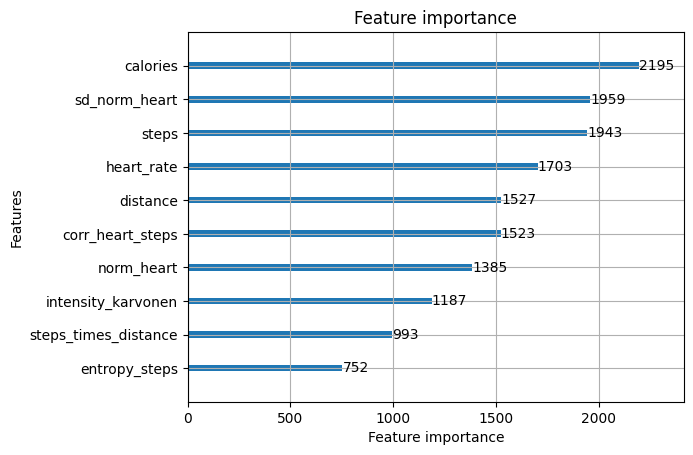

In [33]:
# Create LGBMClassifier with default parameters
ActivityClassifier = lgb.LGBMClassifier()

# Fit the model on training data
# Unlike statsmoels, in sklearn and LightGBM, .fit() modifies the object in-place
# and returns self
ActivityClassifier.fit(X_train, y_train)

# Inspect model parameters
lgb.plot_importance(ActivityClassifier, max_num_features=10)
plt.show()

### Step 4: Evaluate Model Performance

**Instructions:**
- Make predictions on both train and test sets using `predict()`
- Calculate key metrics:
  - **Accuracy** (overall correctness)
  - **Macro F1-score** (average F1 across all classes, treating each class equally)
  - **Per-class F1-scores** (to see which activities are easier/harder to predict)
- Use `accuracy_score`, `f1_score`, and `classification_report` from `sklearn.metrics`
- Print a summary of the results

In [34]:
# TODO: Import accuracy_score, f1_score, classification_report from sklearn.metrics
# TODO: Make predictions on train and test sets
# TODO: Calculate accuracy for train and test
# TODO: Calculate macro F1-score for train and test
# TODO: Print classification report (shows per-class precision, recall, F1)
# TODO: Store key metrics in variables for later comparison (e.g., test_accuracy, test_f1_macro)

### Step 5: Visualize Results

**Instructions:**
- Create a **confusion matrix** to see which activities are confused with each other
- Use `confusion_matrix` from `sklearn.metrics` and `heatmap` from `seaborn`
- Label the axes with actual activity names (use the label encoder's classes)
- Add a title and format it nicely
- Optionally, create a bar chart of per-class F1-scores to quickly see which classes perform best/worst

In [35]:
# TODO: Import confusion_matrix from sklearn.metrics
# TODO: Calculate confusion matrix on test set
# TODO: Create a heatmap using seaborn
# TODO: Set x and y axis labels to activity names (from label encoder)
# TODO: Add title "Baseline Model - Confusion Matrix"
# TODO: Show the plot

In [36]:
# TODO: (Optional) Create a bar chart of per-class F1-scores
# TODO: Extract per-class F1 from classification_report or calculate manually
# TODO: Plot as a bar chart with activity names on x-axis
# TODO: Add title and labels

### Step 6: Save Baseline Results

**Instructions:**
- Create a summary dictionary or dataframe with the key metrics
- Include: accuracy, macro F1, and any other metrics you want to track
- Save this to a file (CSV or JSON) so you can compare later with the feature-store model
- Optionally, save the confusion matrix plot as a PNG file
- Print a final summary of what you've accomplished

In [37]:
# TODO: Create a results dictionary with key metrics
# TODO: Save results to a file (e.g., '../results/baseline_metrics.json' or '.csv')
# TODO: Save the confusion matrix plot (e.g., '../results/baseline_confusion_matrix.png')
# TODO: Print a summary: "Baseline model complete! Test accuracy: X%, Test F1: Y%"

---

## Next Steps

Once you've completed this baseline model, you'll have:
- ✅ A working LightGBM classifier trained on raw features
- ✅ Performance metrics to use as a comparison baseline
- ✅ Visualizations showing model strengths and weaknesses

In the next phase (1B), we'll rebuild this using **Feast** for feature management, which will demonstrate:
- Point-in-time correctness (preventing data leakage)
- Feature definitions as code
- Consistent feature usage between training and serving